In [185]:
from pymongo import MongoClient

client = MongoClient('localhost', 27017)
mongo = client.hai

In [186]:
import time
time.time()

1512171741.777477

In [354]:
start_time = 1511723570
end_time = int(time.time()) - 3600*12
username = "sean"

In [409]:
query = {"user_name": username, "pose":{"$exists": True}, "detections":{"$exists": True}, "time": {"$gt": start_time, "$lt": time.time()}}
cams = mongo.images.find(query).distinct("cam_id")
print(cams)
cams = ["ipcam0"]

['webcam0', 'ipcam0']


In [410]:
import os
import sys

sys.path.append("..")
os.chdir("/home/sean/HAI/main_server/hai")

In [411]:
%load_ext autoreload
%autoreload 2

import scipy.misc
import matplotlib.pyplot as plt
import controllers.learner.datasets as ds
ds.port = 27017

%matplotlib inline

image_data, time_data = ds.get_event_images3(username, cams, start_time, end_time, stride=5, size=5, skip_incomplete=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
skipped: 17583 picked: 64511
total: 82095


In [412]:
time_data = np.array(time_data)# - start_time
print(time_data[:10])
print(len(image_data), len(time_data))

[1511723575 1511723580 1511723585 1511723590 1511723595 1511723600
 1511723605 1511723610 1511723615 1511723620]
64511 64511


In [413]:
import numpy as np
pose_pts = []
image_data2 = []
time_data2 = []

for i, data in enumerate(image_data):
    pts = []
    for cam_i in range(len(cams)):
        body_pose = data[cam_i]["pose"]["body"]
        if len(body_pose) > 0:
            top_pts, top_c  = None, 0
            for bp in body_pose:
                pt_mat = np.array(bp)
                c_sum = np.max(pt_mat, axis=0)[1] - np.min(pt_mat, axis=0)[0]
                #c_sum = sum(b_pts[2::3])
                #print(b_pts[2::3])
                if c_sum > top_c or top_pts is None:
                    top_c = c_sum
                    top_pts = pt_mat.flatten()
            
            pts.extend(top_pts)
        else:
            pts.extend([0] * (3*18))
            #pts.extend([0] * (3))
    pts = np.array(pts).flatten()
        
    pose_pts.append(pts)
    time_data2.append(time_data[i])
    image_data2.append(data)
time_data2 = np.array(time_data2)
print(time_data2[:10])

[1511723575 1511723580 1511723585 1511723590 1511723595 1511723600
 1511723605 1511723610 1511723615 1511723620]


In [414]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

def plot(x):
    pca = PCA(n_components=5)
    tsne = TSNE(n_components=2)
    x = x.reshape([-1, x.shape[-1]])
    x = StandardScaler().fit_transform(x)
    x = pca.fit_transform(x)
    #x = tsne.fit_transform(x)
    #x = x.reshape([-1, 5])
    #for t in range(start_time, end_time, 3600):
    #cond = np.where(np.logical_and(time_data2>t, time_data2<=t+3600))
    #plt.scatter(x[cond,0],x[cond,1], label=t)
    #plt.scatter(x[:,0], x[:, 1])
    fig, ax = plt.subplots(figsize=(18, 2))
    ax.imshow(x.T, aspect='auto')

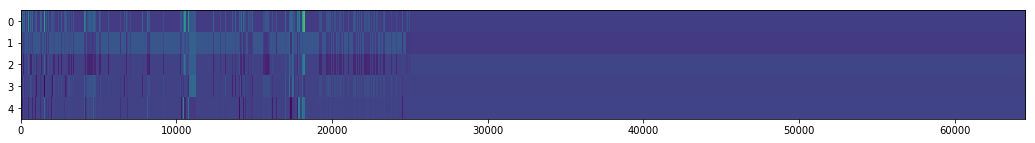

In [415]:
%matplotlib inline
pose_mat = np.array(pose_pts)
plot(pose_mat)
#x = StandardScaler().fit_transform(pose_mat)
#plt.imshow(x.T, aspect='auto')

In [416]:
import cv2
lines = [[0, 1], [1, 2], [2, 3], [3, 4], [1, 5], [5, 6], [6, 7], [0, 14], [14, 16], [0, 15], [15, 17], [1, 8], [8, 9], [9, 10], [1, 11], [11, 12], [12, 13]]

def draw_pose(img, pose):
    for i, (pt1_i, pt2_i) in enumerate(lines):
        pt1 = pose[pt1_i]
        pt2 = pose[pt2_i]
        
        if pt1[2] < 0.05 or pt2[2] < 0.05:
            continue
            
        a = np.array([[[i*20, 255, 255]]], dtype=np.uint8)
        col = cv2.cvtColor(a, cv2.COLOR_HSV2BGR)[0][0]
        col = (int(col[0]), int(col[1]), int(col[2]))
        img = cv2.circle(img, (int(pt1[0]), int(pt1[1])), 10, col, -1)
        img = cv2.circle(img, (int(pt2[0]), int(pt2[1])), 10, col, -1)
        img = cv2.line(img, (int(pt1[0]), int(pt1[1])), (int(pt2[0]), int(pt2[1])), col, 5)
    
    return img

In [487]:
query = {"user_name": username, "pose.body":{"$exists": True}, "detections":{"$exists": True}, "cam_id":"ipcam0"}
latest_img = mongo.images.find(query).limit(1).sort([("time",-1)])[0]

2519
[ 333.22929721  138.65905375  409.97449427]


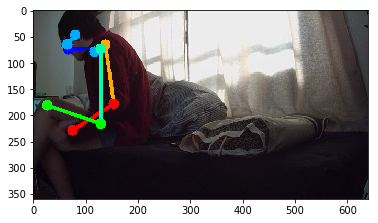

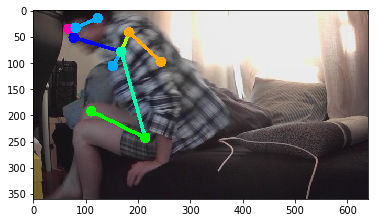

In [488]:
img = imread("images/raw_images/" + latest_img["filename"])
plt.figure()
img = draw_pose(img, latest_img["pose"]["body"][0])
plt.imshow(img)

pts = []
for tup in latest_img["pose"]["body"][0]:
    pts.extend(tup)

from sklearn.pipeline import Pipeline
pipe = Pipeline([("std", StandardScaler())])#, ("pca", PCA(n_components=50))])
x = pipe.fit_transform(pose_mat)
feats = pipe.transform([pts])[0]

from scipy.misc import imread
corr = np.sum((x - feats)**2.0, axis=1)
top_match = np.argmin(corr, axis=0)
print(top_match)
print(corr[top_match-1:top_match+2])
#top_match = image_data2[top_match]
img = imread("images/raw_images/" + image_data2[top_match][0]["filename"])
img = draw_pose(img, pose_mat[top_match].reshape((-1, 3)))
plt.figure()
plt.imshow(img)

TypeError: Image data cannot be converted to float

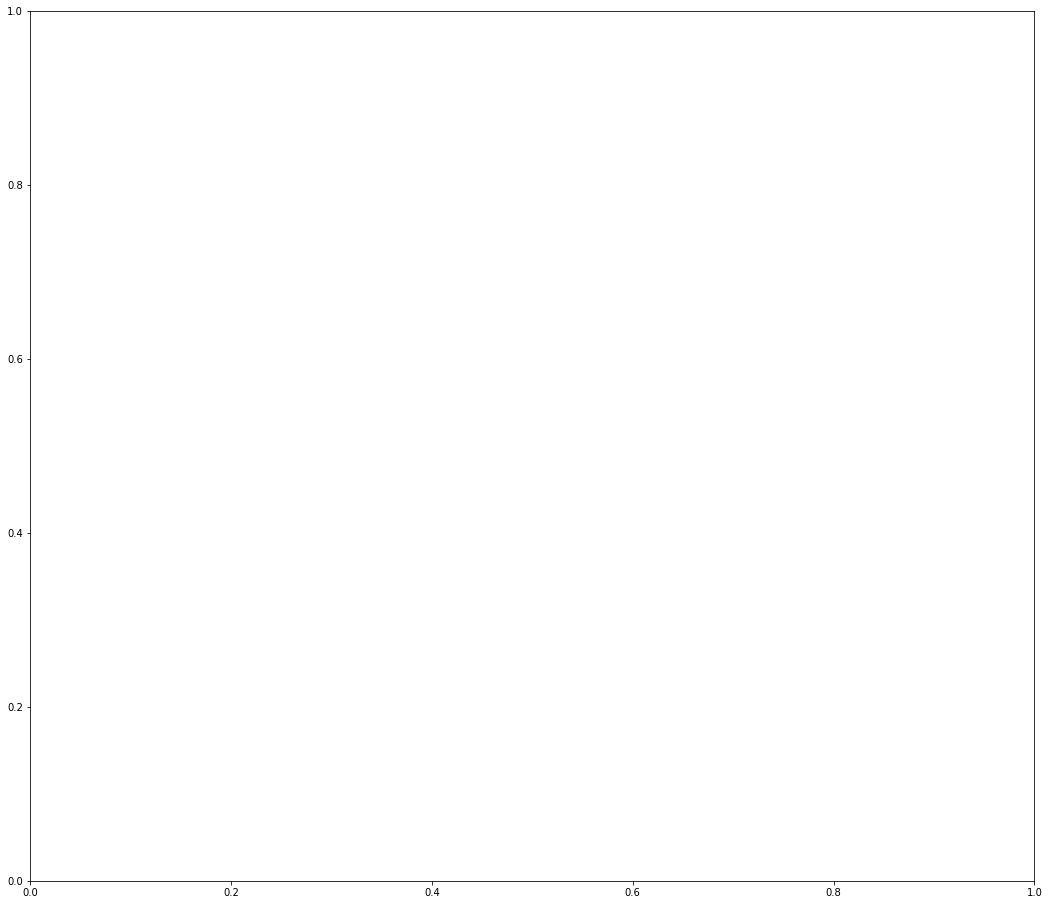

In [348]:
from scipy.misc import imread
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def lineplot(x):
    pca = PCA(n_components=1)
    tsne = TSNE(n_components=1)
    x = x.reshape([-1, x.shape[-1]])
    x = StandardScaler().fit_transform(x)
    x = pca.fit_transform(x)
    #x = tsne.fit_transform(x)
    #for t in range(start_time, end_time, 3600):
    #    cond = np.where(np.logical_and(time_data2>t, time_data2<=t+3600))
    
    plt.figure(figsize=(18, 16))
    ax = plt.gca()

    for i, xx in enumerate(x):
        #print("images/raw_images/" + image_data2[i][0]["filename"])
        img = imread("images/raw_images/" + image_data2[i][0]["filename"])
        im = OffsetImage(img, zoom=0.1)
        ab = AnnotationBbox(im, (time_data2[i], xx), xycoords='data', frameon=False)
        ax.add_artist(ab)

    ax.update_datalim(np.column_stack([time_data2, x]))
    ax.autoscale()
    plt.show()
    
    plt.plot(time_data2, x, "o")
    
lineplot(np.array(pose_pts))